In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import f_oneway
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [2]:
df = pd.read_json("results.jsonl", lines=True)
print(len(df))
df.head()

95


,id,name,params.dataset.path,params.dataset.name,params.dataset.split,params.qa.model,params.qa.temperature,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,...,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1,params.qa.technique,params.qa.n_shot
0,91ebe20fe8a388b1c71c114fbb25764fcedde7b8,flown-male,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.7,ccot/format-reasoning.txt,cq.txt,ccot-2-shot-reasoning.json,...,0.594952,0.708332,0.622204,0.732432,0.592105,0.717197,0.516049,0.617192,CCOT,2
1,4ba978b5fb64b4eb74b472a8ca39f127f941c391,lowse-cors,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.7,ccot/format-reasoning.txt,cq.txt,ccot-2-shot-reasoning.json,...,0.591229,0.709147,0.623802,0.737506,0.582895,0.713528,0.506173,0.613257,CCOT,2
2,b2866a80ace01af98c654cada0998e5aa32dcc83,bovid-pond,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.7,ccot/format-reasoning.txt,cq.txt,ccot-2-shot-reasoning.json,...,0.597849,0.709789,0.626997,0.735712,0.586842,0.706127,0.528395,0.636521,CCOT,2
3,ee2efa9914e23da8ba247de9de80f10c530b8fba,dusty-gash,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.5,ccot/format-reasoning.txt,cq.txt,ccot-2-shot-reasoning.json,...,0.596607,0.707981,0.622204,0.730813,0.607895,0.726347,0.496296,0.602931,CCOT,2
4,fa1229507e7d974312eb9e82a4f06a58afbf4a68,sulfa-sham,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.7,ccot/format-thought.txt,cq.txt,ccot-2-shot-thought.json,...,0.606537,0.716160,0.632588,0.739773,0.602632,0.719379,0.533333,0.637126,CCOT,2


In [3]:
param_cols = [col for col in df.columns if col.startswith("params.")]
metric_cols = [col for col in df.columns if col.startswith("metrics.")]
df.drop(
    columns=[
        "id",
        "name",
        "params.dataset.path",
        "params.dataset.name",
        "params.dataset.split",
        "params.qa.model",
    ],
    inplace=True,
)

In [4]:
target_param_cols = [
    "params.qa.technique",
    "params.qa.system_prompt",
    "params.qa.user_prompt_template",
    "params.qa.few_shot_examples",
    "params.qa.temperature",
]
df = df.sort_values(target_param_cols + ["params.run"])
df.reset_index(drop=True, inplace=True)

In [5]:
run_counts = df.groupby(target_param_cols)["params.run"].aggregate(tuple).reset_index()
mask = run_counts["params.run"].map(len) < 3
run_counts.loc[mask]

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.temperature,params.run
4,CCOT,ccot/format-thought.txt,cq.txt,ccot-2-shot-thought.json,0.1,"(1, 3)"


In [6]:
def remove_ext(filename):
    return filename.split(".", 1)[0]

df["params.qa.system_prompt"] = df["params.qa.system_prompt"].map(remove_ext)
df["params.qa.user_prompt_template"] = df["params.qa.user_prompt_template"].map(remove_ext)
df["params.qa.few_shot_examples"] = df["params.qa.few_shot_examples"].map(remove_ext)

In [7]:
df[target_param_cols + metric_cols].sort_values('metrics.f1', ascending=False).head(10)

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
56,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.7,0.639222,0.753153,0.665335,0.770206,0.650000,0.781398,0.538272,0.647436
60,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-2,0.1,0.642118,0.749716,0.666134,0.766545,0.648684,0.776322,0.555556,0.647764
64,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-2,0.3,0.636326,0.748966,0.661342,0.767986,0.646053,0.774351,0.540741,0.642532
54,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.5,0.638808,0.748716,0.658946,0.762757,0.657895,0.781491,0.540741,0.643805
55,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.5,0.639222,0.748642,0.662141,0.765277,0.656579,0.784169,0.535802,0.630546
62,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-2,0.3,0.639636,0.748071,0.663738,0.765736,0.656579,0.778543,0.533333,0.636282
59,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-2,0.1,0.639636,0.747852,0.661342,0.765014,0.650000,0.773138,0.553086,0.647349
52,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.3,0.636740,0.747799,0.661342,0.764182,0.647368,0.779041,0.540741,0.638527
53,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.5,0.636326,0.746978,0.663738,0.768304,0.644737,0.768149,0.535802,0.641325
65,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-2,0.5,0.634257,0.746677,0.658946,0.765879,0.644737,0.772841,0.538272,0.638221


In [8]:
df['params.qa.system_prompt'].unique()

array(['ccot/format-reasoning', 'ccot/format-thought',
       'cot/format-minimal', 'cot/format-think',
       'cte/excellent-format-few', 'direct/helpful-output-format-few',
       'direct/minimal-output-format-few'], dtype=object)

In [9]:
avg_df = df.groupby(target_param_cols)[metric_cols].mean().reset_index()
avg_df.head()

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
0,CCOT,ccot/format-reasoning,cq,ccot-2-shot-reasoning,0.1,0.603227,0.711235,0.632055,0.737157,0.600000,0.715029,0.520165,0.623983
1,CCOT,ccot/format-reasoning,cq,ccot-2-shot-reasoning,0.3,0.605710,0.714034,0.636315,0.739762,0.598246,0.716252,0.525103,0.630337
2,CCOT,ccot/format-reasoning,cq,ccot-2-shot-reasoning,0.5,0.598400,0.708999,0.626464,0.733536,0.603070,0.721051,0.502881,0.610534
3,CCOT,ccot/format-reasoning,cq,ccot-2-shot-reasoning,0.7,0.594677,0.709089,0.624334,0.735217,0.587281,0.712284,0.516872,0.622323
4,CCOT,ccot/format-thought,cq,ccot-2-shot-thought,0.1,0.609019,0.718808,0.635383,0.743340,0.605263,0.720773,0.534568,0.639285


In [10]:
# find the rows with max f1 score for each technique group
max_f1_rows = avg_df.groupby('params.qa.technique')["metrics.f1"].idxmax()
best_df = avg_df.loc[max_f1_rows, target_param_cols + metric_cols].sort_values('metrics.f1', ascending=False)
best_df

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
18,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.5,0.638119,0.748112,0.661608,0.765446,0.653070,0.777937,0.537449,0.638559
6,CCOT,ccot/format-thought,cq,ccot-2-shot-thought,0.5,0.609985,0.719994,0.637913,0.744879,0.603947,0.721825,0.534979,0.639632
24,Direct,direct/helpful-output-format-few,cq,direct-2-shot,0.1,0.607227,0.717269,0.641906,0.748478,0.596053,0.716336,0.520988,0.622539
8,COT,cot/format-minimal,cq,cot-2-shot,0.1,0.536478,0.644726,0.602769,0.711864,0.491228,0.607840,0.416461,0.506396


## Visualizations

In [11]:
def prepare_data(dataf):
    # Simplify column names for use in formula
    dataf = dataf[target_param_cols + ['params.run'] + metric_cols[:2]].rename(
        columns={
            col: col.replace("params.qa.", "").replace("params.", "").replace("metrics.", "")
            for col in dataf.columns
        }
    )

    # Combine prompts into a single column for simplicity
    dataf["prompt"] = (
        dataf["system_prompt"]
        + " | "
        + dataf["user_prompt_template"]
        + " | "
        + dataf["few_shot_examples"].map(str)
    )

    return dataf


In [12]:
def plot_variance(dataf, figsize=(12, 8), legend='auto', legend_loc='lower left'):  
    plt.figure(figsize=figsize)
    sns.lineplot(x='temperature', y='f1', hue='prompt', data=dataf, linewidth=2.5, legend=legend)
    plt.title("F1 Scores by Prompt and Temperature")
    plt.xlabel("Temperature")
    plt.ylabel("F1 Score")
    if legend:
        plt.legend(loc=legend_loc)
    plt.tight_layout()
    plt.show()

In [13]:
prepared_df = prepare_data(df)
temperature_mask = prepared_df["temperature"] <= 1.0
zero_shot_mask = prepared_df["few_shot_examples"] == 'empty'
prepared_df

,technique,system_prompt,user_prompt_template,few_shot_examples,temperature,run,exact_match,f1,prompt
0,CCOT,ccot/format-reasoning,cq,ccot-2-shot-reasoning,0.1,1,0.604055,0.713883,ccot/format-reasoning | cq | ccot-2-shot-reaso...
1,CCOT,ccot/format-reasoning,cq,ccot-2-shot-reasoning,0.1,2,0.604882,0.710308,ccot/format-reasoning | cq | ccot-2-shot-reaso...
2,CCOT,ccot/format-reasoning,cq,ccot-2-shot-reasoning,0.1,3,0.600745,0.709515,ccot/format-reasoning | cq | ccot-2-shot-reaso...
3,CCOT,ccot/format-reasoning,cq,ccot-2-shot-reasoning,0.3,1,0.602813,0.711889,ccot/format-reasoning | cq | ccot-2-shot-reaso...
4,CCOT,ccot/format-reasoning,cq,ccot-2-shot-reasoning,0.3,2,0.611916,0.718380,ccot/format-reasoning | cq | ccot-2-shot-reaso...
...,...,...,...,...,...,...,...,...,...
90,Direct,direct/minimal-output-format-few,cq,direct-2-shot,0.5,2,0.593711,0.712103,direct/minimal-output-format-few | cq | direct...
91,Direct,direct/minimal-output-format-few,cq,direct-2-shot,0.5,3,0.599090,0.711090,direct/minimal-output-format-few | cq | direct...
92,Direct,direct/minimal-output-format-few,cq,direct-2-shot,0.7,1,0.594125,0.709393,direct/minimal-output-format-few | cq | direct...
93,Direct,direct/minimal-output-format-few,cq,direct-2-shot,0.7,2,0.586678,0.706467,direct/minimal-output-format-few | cq | direct...


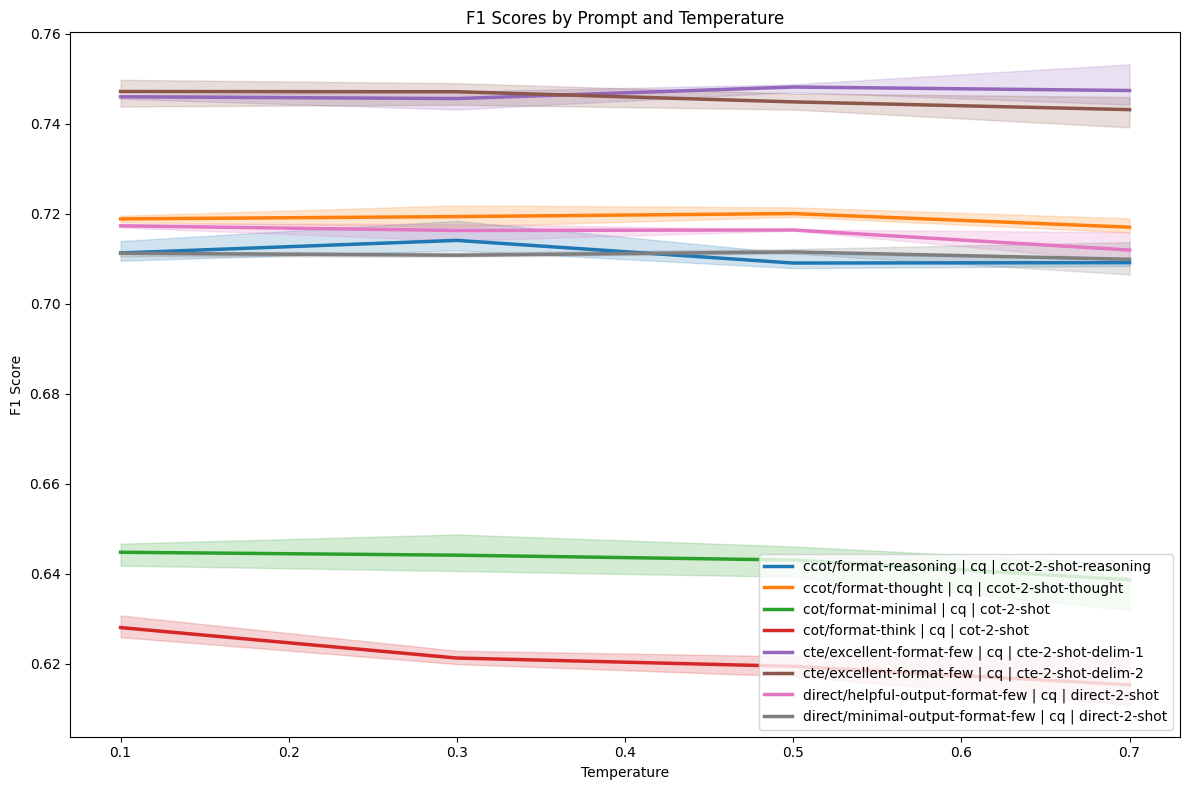

In [14]:
plot_variance(prepared_df, legend_loc='lower right')

## Statistical Testing

In [15]:
def two_way_anova(dataf):
    if dataf.empty:
        raise ValueError("No data to perform ANOVA")
    # Perform Two-Way ANOVA with replication
    formula = "f1 ~ C(prompt) + C(temperature) + C(prompt):C(temperature)"
    model = ols(formula, data=dataf).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print("Two-Way ANOVA Results:")
    print(anova_table)


def one_way_anova_by_temperature(dataf):
    if dataf.empty:
        raise ValueError("No data to perform ANOVA")
    # Perform One-Way ANOVA at each temperature
    temperatures = dataf["temperature"].unique()
    for temp in temperatures:
        temp_data = dataf[dataf["temperature"] == temp]
        grouped = temp_data.groupby("prompt")["f1"].apply(list).reset_index()
        f1_scores = grouped["f1"]

        if len(f1_scores) < 2:
            print(f"Skipping temperature {temp}: Not enough groups to perform ANOVA")
            continue

        anova_result = f_oneway(*f1_scores)
        print(f"One-Way ANOVA for Temperature {temp:.1f}:")
        print(
            f"F-statistic: {anova_result.statistic:.4f}, p-value: {anova_result.pvalue:.4e}"
        )

In [16]:
def report(dataf, alpha=0.005):
    print("Prompt values")
    for prompt in dataf.prompt.unique():
        print("\t", prompt)
    print("\n")
    print("Temperature values: ", ', '.join([f"{t:.1f}" for t in dataf.temperature.unique()]))
    print("\n")
    # Two-Way ANOVA
    two_way_anova(dataf)
    print("\n")
    
    # One-Way ANOVA by Temperature
    one_way_anova_by_temperature(dataf)
    print("\n")
    
    # Tukey’s HSD
    tukey = pairwise_tukeyhsd(endog=dataf['f1'], groups=dataf['prompt'], alpha=alpha)
    print(tukey)

### Direct technique

In [17]:
direct_prompt_mask = prepared_df["technique"] == "Direct"
direct_prompt_prepared_df = prepared_df[direct_prompt_mask & temperature_mask]
direct_prompt_prepared_df

,technique,system_prompt,user_prompt_template,few_shot_examples,temperature,run,exact_match,f1,prompt
71,Direct,direct/helpful-output-format-few,cq,direct-2-shot,0.1,1,0.605296,0.717192,direct/helpful-output-format-few | cq | direct...
72,Direct,direct/helpful-output-format-few,cq,direct-2-shot,0.1,2,0.608192,0.717716,direct/helpful-output-format-few | cq | direct...
73,Direct,direct/helpful-output-format-few,cq,direct-2-shot,0.1,3,0.608192,0.716897,direct/helpful-output-format-few | cq | direct...
74,Direct,direct/helpful-output-format-few,cq,direct-2-shot,0.3,1,0.604468,0.717065,direct/helpful-output-format-few | cq | direct...
75,Direct,direct/helpful-output-format-few,cq,direct-2-shot,0.3,2,0.606123,0.717698,direct/helpful-output-format-few | cq | direct...
76,Direct,direct/helpful-output-format-few,cq,direct-2-shot,0.3,3,0.602813,0.713958,direct/helpful-output-format-few | cq | direct...
77,Direct,direct/helpful-output-format-few,cq,direct-2-shot,0.5,1,0.599504,0.716174,direct/helpful-output-format-few | cq | direct...
78,Direct,direct/helpful-output-format-few,cq,direct-2-shot,0.5,2,0.604055,0.716409,direct/helpful-output-format-few | cq | direct...
79,Direct,direct/helpful-output-format-few,cq,direct-2-shot,0.5,3,0.604882,0.716454,direct/helpful-output-format-few | cq | direct...
80,Direct,direct/helpful-output-format-few,cq,direct-2-shot,0.7,1,0.598676,0.710515,direct/helpful-output-format-few | cq | direct...


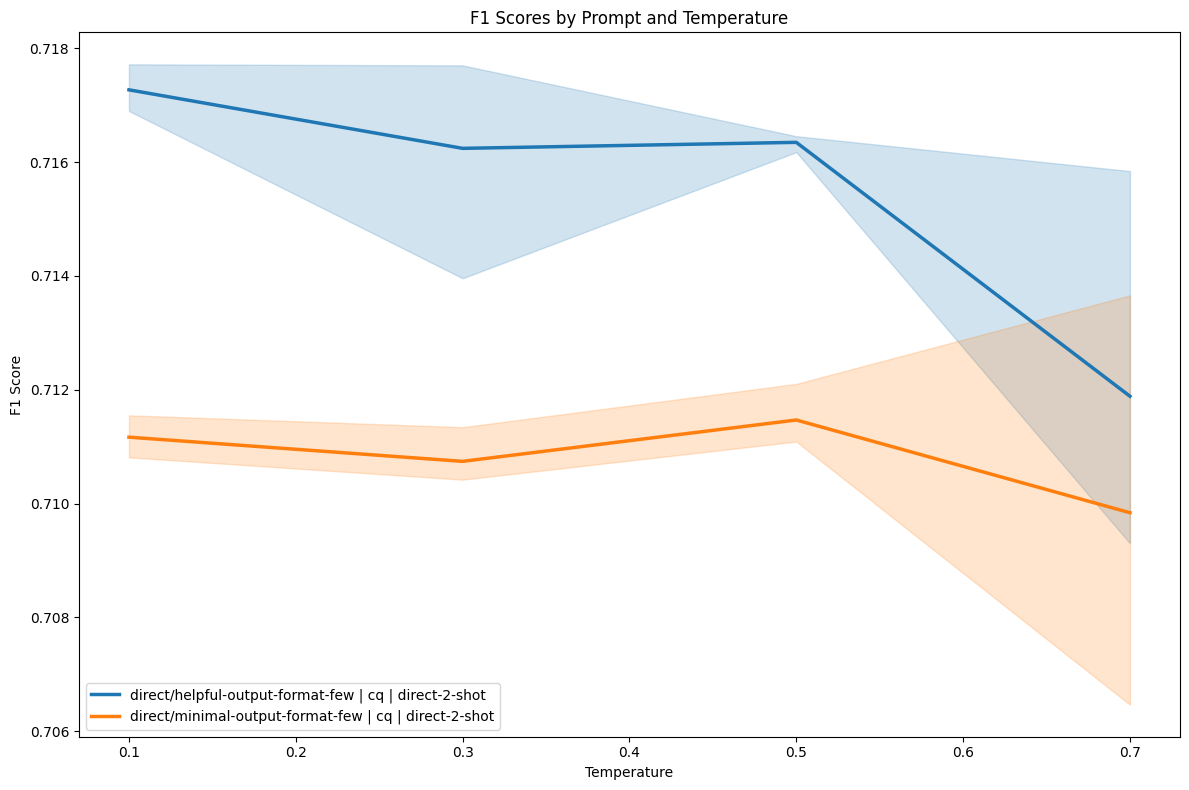

In [18]:
plot_variance(direct_prompt_prepared_df, legend='brief')

In [19]:
report(direct_prompt_prepared_df)

Prompt values
	 direct/helpful-output-format-few | cq | direct-2-shot
	 direct/minimal-output-format-few | cq | direct-2-shot


Temperature values:  0.1, 0.3, 0.5, 0.7


Two-Way ANOVA Results:
                            sum_sq    df          F    PR(>F)
C(prompt)                 0.000129   1.0  33.974696  0.000026
C(temperature)            0.000042   3.0   3.726857  0.033176
C(prompt):C(temperature)  0.000014   3.0   1.274876  0.316644
Residual                  0.000061  16.0        NaN       NaN


One-Way ANOVA for Temperature 0.1:
F-statistic: 215.4761, p-value: 1.2532e-04
One-Way ANOVA for Temperature 0.3:
F-statistic: 21.2092, p-value: 9.9906e-03
One-Way ANOVA for Temperature 0.5:
F-statistic: 217.6484, p-value: 1.2287e-04
One-Way ANOVA for Temperature 0.7:
F-statistic: 0.4990, p-value: 5.1892e-01


                                               Multiple Comparison of Means - Tukey HSD, FWER=0.01                                                
                        group1       

In [20]:
# Tukey’s HSD
_data = direct_prompt_prepared_df.loc[~zero_shot_mask]
tukey = pairwise_tukeyhsd(endog=_data['f1'], groups=_data['prompt'], alpha=0.005)
print(tukey)


                                               Multiple Comparison of Means - Tukey HSD, FWER=0.01                                                
                        group1                                                group2                        meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------------------------------------------------------------------------------
direct/helpful-output-format-few | cq | direct-2-shot direct/minimal-output-format-few | cq | direct-2-shot  -0.0046 0.0001 -0.0076 -0.0017   True
--------------------------------------------------------------------------------------------------------------------------------------------------


## COT

In [21]:
cot_prompt_mask = prepared_df["technique"] == "COT"
cot_prompt_prepared_df = prepared_df[cot_prompt_mask & temperature_mask]

In [22]:
cot_prompt_prepared_df.groupby("prompt")["f1"].mean().sort_values(ascending=False)

prompt
cot/format-minimal | cq | cot-2-shot    0.642610
cot/format-think | cq | cot-2-shot      0.620965
Name: f1, dtype: float64

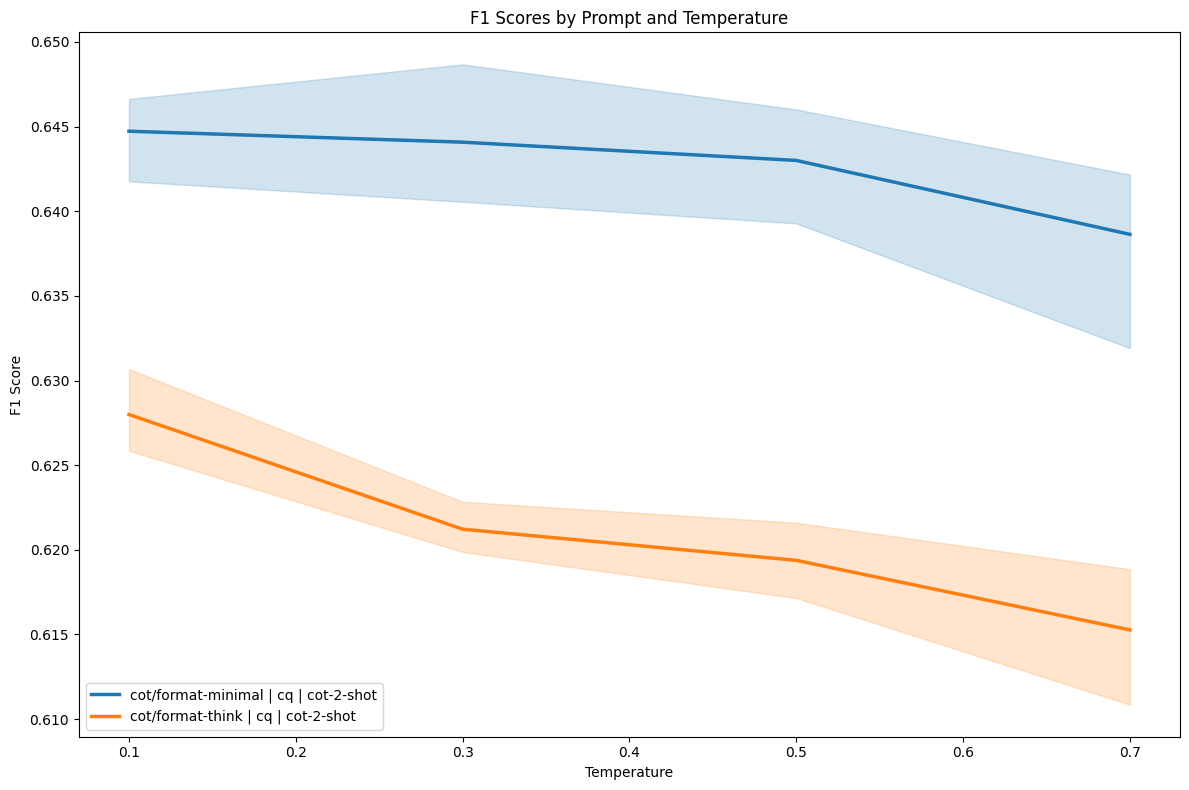

In [23]:
plot_variance(cot_prompt_prepared_df)

In [24]:
report(cot_prompt_prepared_df)

Prompt values
	 cot/format-minimal | cq | cot-2-shot
	 cot/format-think | cq | cot-2-shot


Temperature values:  0.1, 0.3, 0.5, 0.7


Two-Way ANOVA Results:
                            sum_sq    df           F        PR(>F)
C(prompt)                 0.002811   1.0  196.163292  2.127032e-10
C(temperature)            0.000272   3.0    6.335496  4.895635e-03
C(prompt):C(temperature)  0.000049   3.0    1.133180  3.654333e-01
Residual                  0.000229  16.0         NaN           NaN


One-Way ANOVA for Temperature 0.1:
F-statistic: 65.7285, p-value: 1.2584e-03
One-Way ANOVA for Temperature 0.3:
F-statistic: 80.0083, p-value: 8.6404e-04
One-Way ANOVA for Temperature 0.5:
F-statistic: 100.5328, p-value: 5.5625e-04
One-Way ANOVA for Temperature 0.7:
F-statistic: 24.9605, p-value: 7.5114e-03


                            Multiple Comparison of Means - Tukey HSD, FWER=0.01                             
               group1                              group2               meandiff p-adj

### All techniques

In [25]:
best_df['params.run'] = 0
best_prompts = prepare_data(best_df).prompt.values.tolist()
_data = prepared_df.copy()
prompt_mask = _data['prompt'].isin(best_prompts)
best_prepared_data = _data.loc[prompt_mask&temperature_mask]
best_prepared_data

,technique,system_prompt,user_prompt_template,few_shot_examples,temperature,run,exact_match,f1,prompt
12,CCOT,ccot/format-thought,cq,ccot-2-shot-thought,0.1,1,0.610261,0.719511,ccot/format-thought | cq | ccot-2-shot-thought
13,CCOT,ccot/format-thought,cq,ccot-2-shot-thought,0.1,3,0.607778,0.718106,ccot/format-thought | cq | ccot-2-shot-thought
14,CCOT,ccot/format-thought,cq,ccot-2-shot-thought,0.3,1,0.604882,0.717042,ccot/format-thought | cq | ccot-2-shot-thought
15,CCOT,ccot/format-thought,cq,ccot-2-shot-thought,0.3,2,0.605296,0.719131,ccot/format-thought | cq | ccot-2-shot-thought
16,CCOT,ccot/format-thought,cq,ccot-2-shot-thought,0.3,3,0.610261,0.721803,ccot/format-thought | cq | ccot-2-shot-thought
17,CCOT,ccot/format-thought,cq,ccot-2-shot-thought,0.5,1,0.613571,0.721371,ccot/format-thought | cq | ccot-2-shot-thought
18,CCOT,ccot/format-thought,cq,ccot-2-shot-thought,0.5,2,0.607778,0.719352,ccot/format-thought | cq | ccot-2-shot-thought
19,CCOT,ccot/format-thought,cq,ccot-2-shot-thought,0.5,3,0.608606,0.719260,ccot/format-thought | cq | ccot-2-shot-thought
20,CCOT,ccot/format-thought,cq,ccot-2-shot-thought,0.7,1,0.604055,0.715808,ccot/format-thought | cq | ccot-2-shot-thought
21,CCOT,ccot/format-thought,cq,ccot-2-shot-thought,0.7,2,0.606537,0.716160,ccot/format-thought | cq | ccot-2-shot-thought


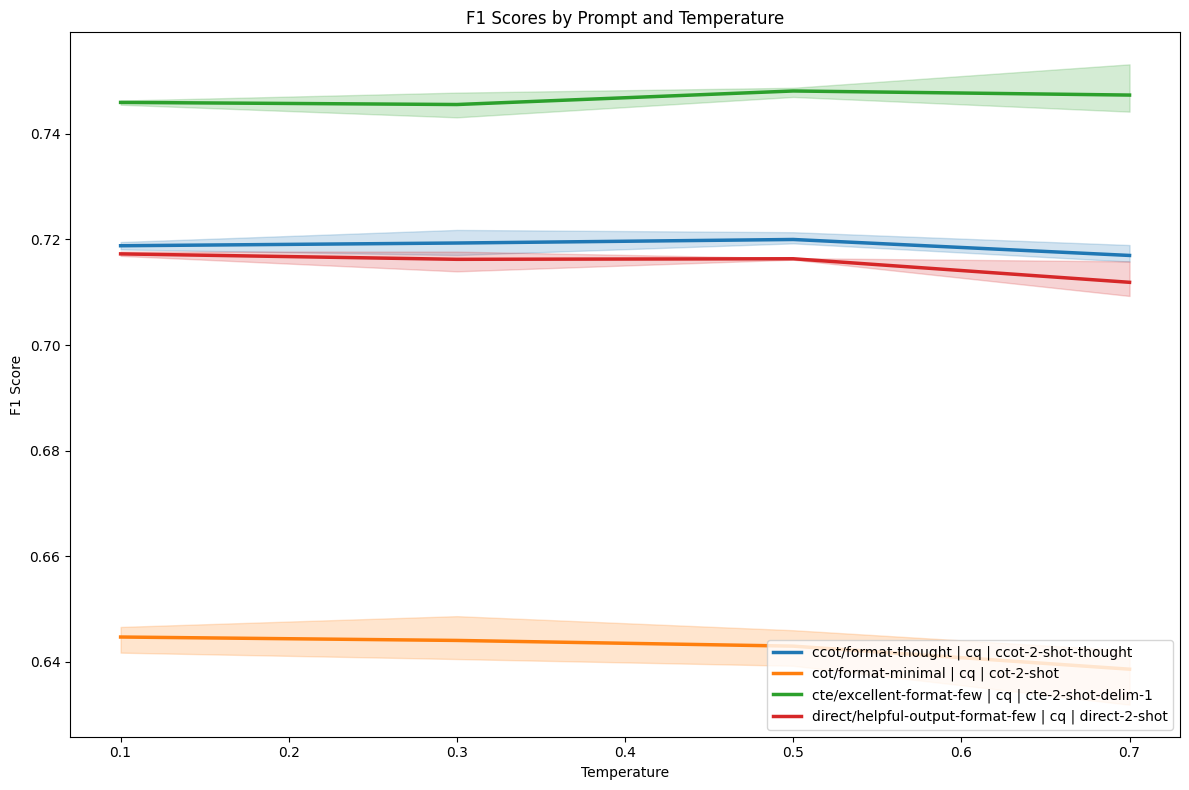

In [26]:
plot_variance(best_prepared_data, figsize=(12, 8), legend_loc='lower right')

In [27]:
report(best_prepared_data)

Prompt values
	 ccot/format-thought | cq | ccot-2-shot-thought
	 cot/format-minimal | cq | cot-2-shot
	 cte/excellent-format-few | cq | cte-2-shot-delim-1
	 direct/helpful-output-format-few | cq | direct-2-shot


Temperature values:  0.1, 0.3, 0.5, 0.7


Two-Way ANOVA Results:
                            sum_sq    df            F        PR(>F)
C(prompt)                 0.071000   3.0  2851.564401  6.306055e-38
C(temperature)            0.000079   3.0     3.167872  3.811013e-02
C(prompt):C(temperature)  0.000069   9.0     0.926631  5.160405e-01
Residual                  0.000257  31.0          NaN           NaN


One-Way ANOVA for Temperature 0.1:
F-statistic: 2580.2626, p-value: 5.1593e-11
One-Way ANOVA for Temperature 0.3:
F-statistic: 698.0547, p-value: 5.1539e-10
One-Way ANOVA for Temperature 0.5:
F-statistic: 1712.9478, p-value: 1.4356e-11
One-Way ANOVA for Temperature 0.7:
F-statistic: 343.0316, p-value: 8.6865e-09


                                              Multiple Compariso

## Inspect

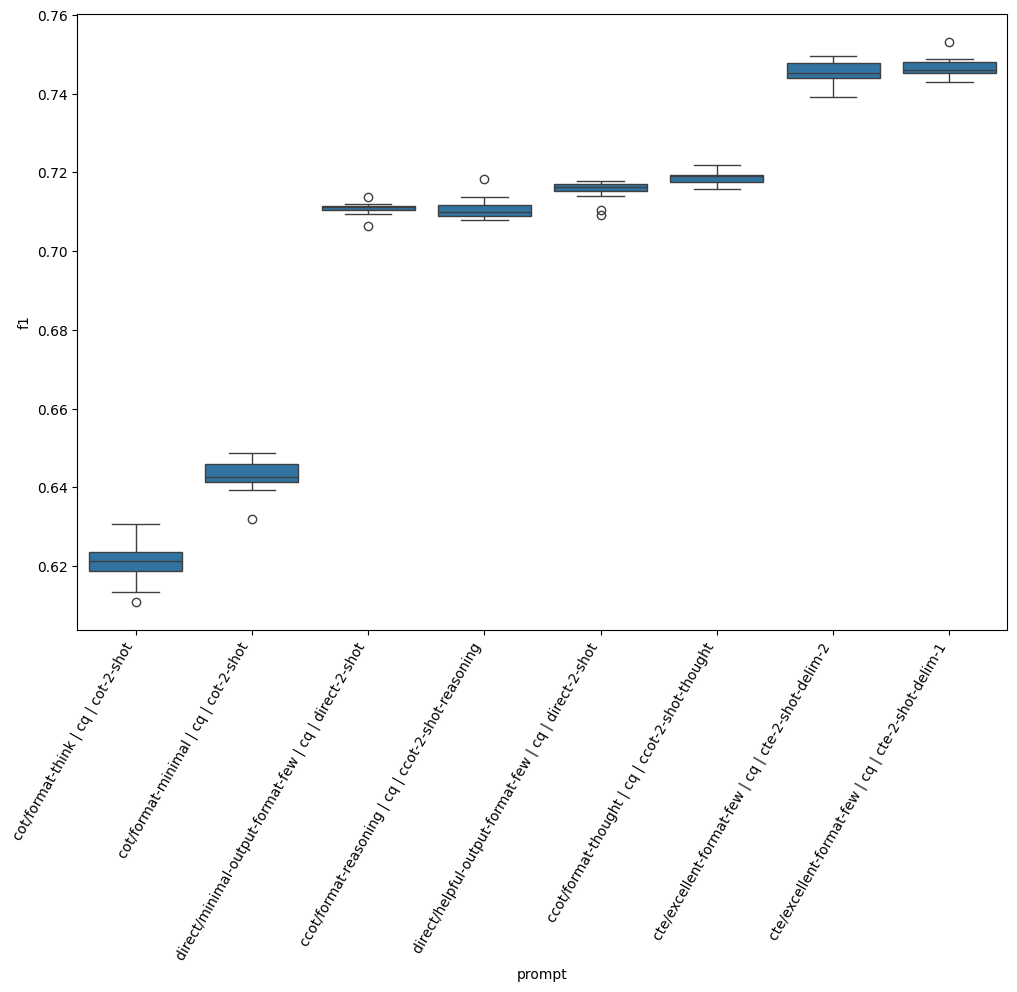

In [28]:
# box-whisker plot
plt.figure(figsize=(12, 8))
sns.boxplot(
    x="prompt",
    y="f1",
    data=prepared_df.loc[temperature_mask].sort_values(by="f1"),
)
plt.xticks(rotation=60, ha="right");